In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
import shap
from imblearn.over_sampling import SMOTE

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('train.csv')

#2. data_preprocessing
# missing D(4개 행 제거)
data.isnull().sum()
nan_data = data.dropna()
print('결측 처리 :' ,nan_data.shape)

# duplicated D(2행 제거)
nan_data[nan_data.duplicated()]
new_data = nan_data[~nan_data.duplicated()]
print('중복 처리 :',new_data.shape)

#encoding : gender-label ( Female = 0, male = 1) /  geography-onehot
le = LabelEncoder()
new_data['Gender'] = le.fit_transform(new_data["Gender"])

oe = OneHotEncoder()
oe.fit(new_data[['Geography']])
geo_csr = oe.transform(new_data[['Geography']])
csr_df = pd.DataFrame(geo_csr.toarray(), columns = oe.get_feature_names_out())
df = new_data.reset_index(drop=True)  # df 인덱스 초기화
csr_df = csr_df.reset_index(drop=True)  # csr_df 인덱스 초기화
inco_df = pd.concat([df,csr_df],axis=1)

#check
int_data = inco_df.drop(columns=['id', 'CustomerId', 'Surname','Geography'])
X = int_data.drop("Exited", axis=1)
y_true = int_data['Exited']
print('전처리 완료:',X.shape,y_true.shape)
print('----------------------------')

#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true, stratify = y_true,test_size = 0.2, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#minmaxscaling - 적용유무 검토 
target_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

mn_sc = MinMaxScaler()
X_train_sc[target_features] = mn_sc.fit_transform(X_train[target_features])
X_test_sc[target_features] = mn_sc.transform(X_test[target_features]) #테스터는 정규화 학습 안함 

#Over Sampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc, y_train)
print("SMOTE 적용 후 데이터 크기:", X_train_res.shape, y_train_res.shape)
print(f'original : {y_train.value_counts()}')
print(f'smote : {y_train_res.value_counts()}')

print('----------------------------')

결측 처리 : (165034, 14)
중복 처리 : (165034, 14)
전처리 완료: (165034, 12) (165034,)
----------------------------
데이터 분리 후 크기 :  (132027, 12) (33007, 12) (132027,) (33007,)
SMOTE 적용 후 데이터 크기: (208180, 12) (208180,)
original : Exited
0    104090
1     27937
Name: count, dtype: int64
smote : Exited
0    104090
1    104090
Name: count, dtype: int64
----------------------------


In [ ]:
# 랜덤 포레스트 기반 K-Means Clustering

clf_dt = RandomForestClassifier(random_state=42,
        max_depth=29,
        min_samples_split=2,
        min_samples_leaf=9,
        n_estimators=213,
        max_features='sqrt')

clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

for name, value in zip(X.columns.tolist(), clf_dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

sns.barplot(x=clf_dt.feature_importances_, y=X.columns.tolist())

In [3]:
# 잔고가 0인 그룹을 배제하기 위한 데이터프레임 복사
df_filtered = data
df_filtered

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,1,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,0,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,1,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,1,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0


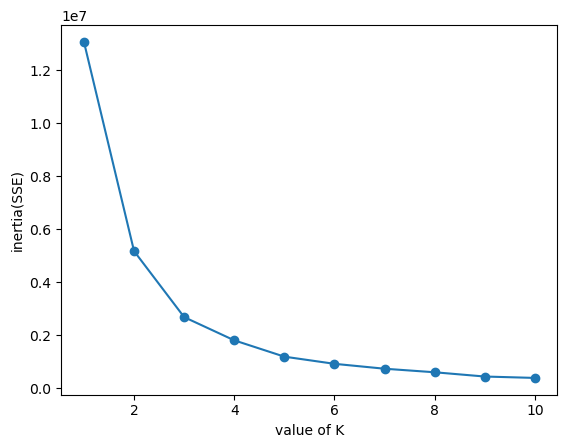

2


In [19]:
# Age, NumOfProducts, IsActiveMember 변수 기준으로 K-Means clustring 진행
from sklearn.cluster import KMeans

X_cluster = df[['Age', 'NumOfProducts', 'IsActiveMember']]

# 각 K값에 대한 오차제곱합 계산 및 시각화
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('value of K')
plt.ylabel('inertia(SSE)')
plt.show()

diff = np.diff(SSE)
optimal_k = np.argmin(diff[1:] - diff[:1]) +2
print(optimal_k)

In [20]:
# 경사가 가장 완만해지는 K값 = 2로 사용해야 하나 그룹 간 특징을 명확하게 하기 위해 k=4로 사용, 1,2번 그룹이 이탈률이 상대적으로 높음
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)
df[['Age', 'NumOfProducts','IsActiveMember' ,'Cluster']].head()

cluster_analysis = df.groupby('Cluster')['Exited'].mean()
print(cluster_analysis)

Cluster
0    0.099016
1    0.541099
2    0.280975
3    0.082649
Name: Exited, dtype: float64


In [21]:
cluster_summery = df.groupby('Cluster').mean(numeric_only=True).drop(['id', 'CustomerId'], axis=1)
cluster_summery

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Cluster,,,,,,,,,,
0,657.025899,0.594640,34.151985,5.034924,51917.637852,1.597756,0.763196,0.519377,112451.580746,0.099016
1,654.773485,0.488048,55.974785,4.929860,65466.302502,1.426924,0.738520,0.532869,112033.567745,0.541099
2,655.985281,0.548637,41.734206,5.026507,57471.400904,1.523346,0.750416,0.457137,112771.895575,0.280975
3,657.350722,0.585368,27.121307,5.038069,52091.444394,1.613530,0.752503,0.512765,112784.783856,0.082649


In [22]:
cluster_summery_mode = df.groupby('Cluster').agg({
    'NumOfProducts' : lambda x : x.mode()[0],
    'HasCrCard' : lambda x : x.mode()[0],
    'IsActiveMember' : lambda x : x.mode()[0]
    })
cluster_summery_mode

,NumOfProducts,HasCrCard,IsActiveMember
Cluster,,,
0,2,1.0,1.0
1,1,1.0,1.0
2,1,1.0,0.0
3,2,1.0,1.0


In [ ]:
# 클러스터별 Age 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Age", data=df)
plt.title("Age Distribution by Cluster")
plt.show()

# 클러스터별 NumOfProducts 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="NumOfProducts", data=df)
plt.title("NumOfProducts Distribution by Cluster")
plt.show()

# 클러스터별 IsActiveMember 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="IsActiveMember", data=df)
plt.title("IsActiveMember Distribution by Cluster")
plt.show()



In [4]:
# 이탈한 사람들의 분포 확인을 위한 clustering 진행
df_filtered = df_filtered[df_filtered['Exited'] != 0]
df_filtered

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5,5,15771669,Genovese,588,Germany,1,36.0,4,131778.58,1,1.0,0.0,136024.31,1
18,18,15671358,Hargreaves,645,Germany,0,55.0,8,120105.43,1,1.0,0.0,125083.29,1
19,19,15650670,Ts'ui,559,France,1,61.0,1,153711.26,1,0.0,1.0,180890.40,1
23,23,15576044,Akabueze,554,Germany,1,44.0,9,121823.26,1,1.0,0.0,79577.68,1
25,25,15671137,Sazonova,703,Spain,1,39.0,9,0.00,1,1.0,0.0,131363.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165007,165007,15674851,Gaffney,767,France,1,38.0,3,0.00,1,1.0,0.0,152872.84,1
165012,165012,15815050,Trevisani,746,Germany,0,60.0,3,108805.42,2,1.0,0.0,78744.37,1
165022,165022,15798960,Hao,577,France,0,45.0,2,0.00,1,0.0,0.0,148811.14,1
165024,165024,15734886,Martin,592,Germany,0,33.0,3,110993.29,2,1.0,1.0,176747.66,1


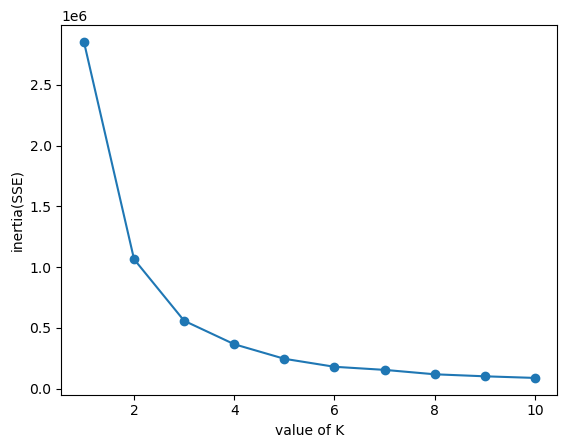

2


In [5]:
# Age, NumOfProducts, IsActiveMember 변수 기준으로 K-Means clustring 진행
from sklearn.cluster import KMeans

X_cluster = df_filtered[['Age', 'NumOfProducts', 'IsActiveMember']]

# 각 K값에 대한 오차제곱합 계산 및 시각화
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('value of K')
plt.ylabel('inertia(SSE)')
plt.show()

diff = np.diff(SSE)
optimal_k = np.argmin(diff[1:] - diff[:1]) +2
print(optimal_k)

In [9]:
# 군집 형성을 위해 K=3 사용
from sklearn.cluster import KMeans

X_cluster = df_filtered[['Age', 'NumOfProducts', 'IsActiveMember']]

kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered['Cluster'] = kmeans.fit_predict(X_cluster)
df_filtered[['Age', 'NumOfProducts','IsActiveMember' ,'Cluster']].head()

,Age,NumOfProducts,IsActiveMember,Cluster
5,36.0,1,0.0,0
18,55.0,1,0.0,1
19,61.0,1,1.0,1
23,44.0,1,0.0,2
25,39.0,1,0.0,0


In [10]:
cluster_summery_filtered = df_filtered.groupby('Cluster').mean(numeric_only=True).drop(['id', 'CustomerId'], axis=1)
cluster_summery_filtered

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Cluster,,,,,,,,,,
0,652.142778,0.443196,33.761542,4.952717,72481.963890,1.350581,0.714724,0.306456,112412.921269,1.0
1,652.788790,0.415042,55.327387,4.847484,71715.866172,1.320119,0.742760,0.332342,114656.074306,1.0
2,651.933599,0.416318,44.391575,4.927297,69996.916929,1.316285,0.746070,0.264013,115670.492702,1.0


In [16]:
cluster_summery_mode = df_filtered.groupby('Cluster').agg({
    'NumOfProducts' : lambda x : x.mode()[0],
    'HasCrCard' : lambda x : x.mode()[0],
    'IsActiveMember' : lambda x : x.mode()[0]
    })
cluster_summery_mode

,NumOfProducts,HasCrCard,IsActiveMember
Cluster,,,
0,1,1.0,0.0
1,1,1.0,0.0
2,1,1.0,0.0


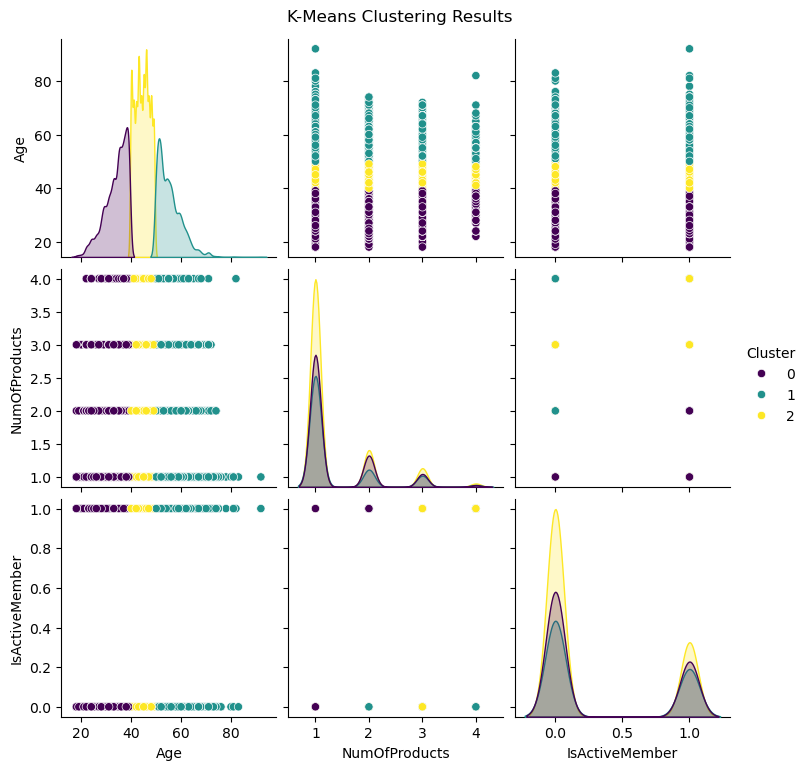

In [13]:
# 산점도를 통한 군집 시각화
selected_features = ['Age', 'NumOfProducts', 'IsActiveMember']
sns.pairplot(df_filtered, vars = selected_features ,hue="Cluster", palette="viridis", diag_kind="kde")
plt.suptitle("K-Means Clustering Results", y=1.02)
plt.show()

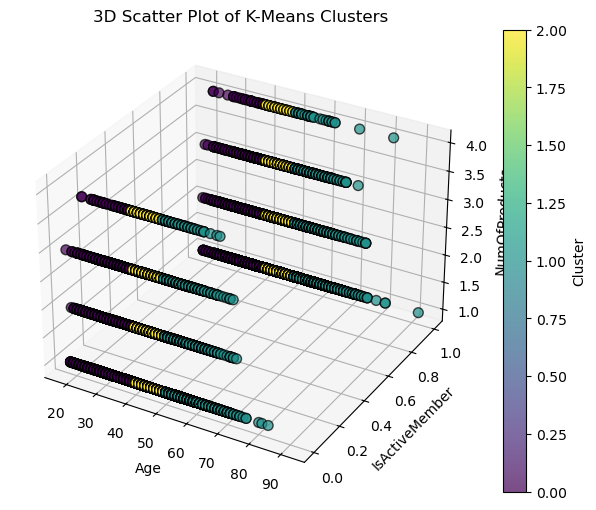

In [11]:
# 3D 산점도 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 클러스터별 색상 설정
scatter = ax.scatter(df_filtered["Age"], df_filtered["IsActiveMember"], df_filtered["NumOfProducts"],
                     c=df_filtered["Cluster"], cmap="viridis", s=50, alpha=0.7, edgecolors='k')

# 축 라벨 설정
ax.set_xlabel("Age")
ax.set_ylabel("IsActiveMember")
ax.set_zlabel("NumOfProducts")
ax.set_title("3D Scatter Plot of K-Means Clusters")

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label="Cluster")

# 그래프 표시
plt.show()

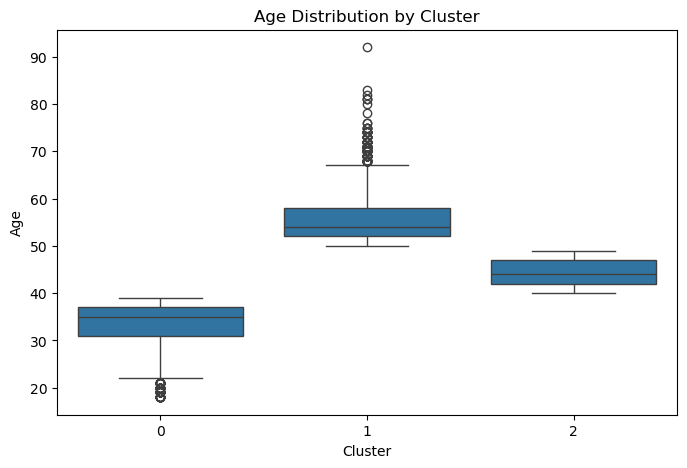

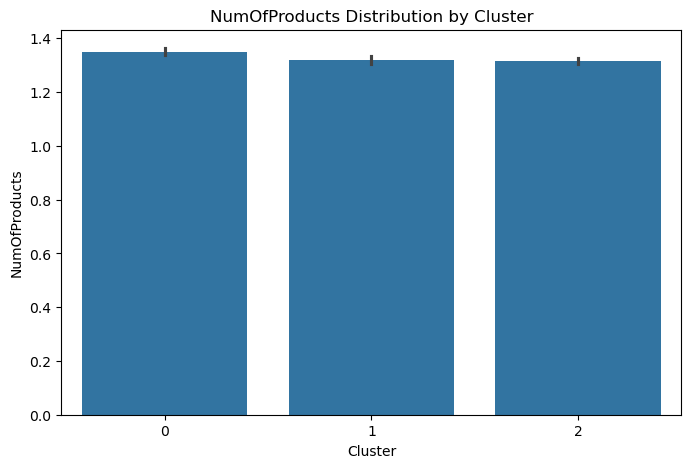

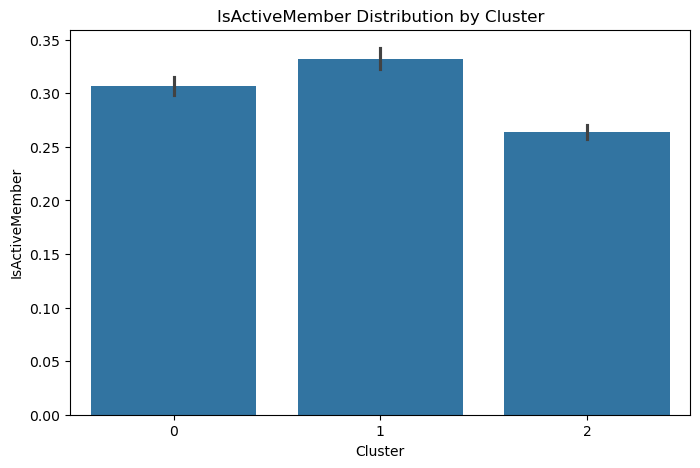

In [15]:
# 클러스터별 Age 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Age", data=df_filtered)
plt.title("Age Distribution by Cluster")
plt.show()

# 클러스터별 NumOfProducts 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="NumOfProducts", data=df_filtered)
plt.title("NumOfProducts Distribution by Cluster")
plt.show()

# 클러스터별 IsActiveMember 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="IsActiveMember", data=df_filtered)
plt.title("IsActiveMember Distribution by Cluster")
plt.show()